In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np

class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes):
        super(BasicBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size= 1, stride= 1, padding= 0, bias= False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, in_planes, kernel_size= 3, stride= 1, padding= 1, bias= False)
        self.bn2 = nn.BatchNorm2d(in_planes)
    
    def forward(self, x):
        out = F.leaky_relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += x
        out = F.leaky_relu(out)
        return out

class DownSample(nn.Module):
    def __init__(self, in_planes, planes):
        super(DownSample, self).__init__()

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size= 3, stride= 2, padding= 1, bias = False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, in_planes, kernel_size= 1, stride= 1, padding= 0, bias = False)
        self.bn2 = nn.BatchNorm2d(in_planes)
        self.conv3 = nn.Conv2d(in_planes, planes, kernel_size= 3, stride= 1, padding= 1, bias= False)
        self.bn3 = nn.BatchNorm2d(planes)

    def forward(self, x):
        out_1 = F.leaky_relu(self.bn1(self.conv1(x)))
        out = F.leaky_relu(self.bn2(self.conv2(out_1)))
        out = self.bn3(self.conv3(out))
        out += out_1
        out = F.leaky_relu(out)
        return out

class PAE(nn.Module):

    def __init__(self, img_size = 640):
        super(PAE, self).__init__()
        
        # 0
        self.conv1 = nn.Conv2d(3, 32, kernel_size= 3, stride= 1, padding= 1, bias= False)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.layer1 = self._add_DownSample_layer(32, 64, 2) # 1 ~ 8
        self.layer2 = self._add_BasicBlock_layer(128, 64, 1) # 9 ~ 11
        self.layer3 = self._add_DownSample_layer(128, 256, 1) # 12 ~ 15
        self.layer4 = self._add_BasicBlock_layer(256, 128, 7) # 16 ~ 36
        self.layer5 = self._add_DownSample_layer(256, 512, 1) # 37 ~ 40
        self.layer6 = self._add_BasicBlock_layer(512, 256, 4) # 41 ~ 52
        self.layer7 = self._add_DownSample_layer(512, 512, 1) # 53 ~ 56
        self.layer8 = self._add_BasicBlock_layer(512, 256, 3) # 57 ~ 65
        self.layer9 = self._add_DownSample_layer(512, 512, 1) # 66 ~ 69
        self.layer10 = self._add_BasicBlock_layer(512, 256, 2) # 70 ~ 75
        self.layer11 = self._add_DownSample_layer(512, 512, 1) # 76 ~ 79
        self.layer12 = self._add_BasicBlock_layer(512, 256, 2) # 80 ~ 85

        # 86
        self.conv2 = nn.Conv2d(512, 256, kernel_size= 1, stride =1 , padding= 0, bias= False)
        self.bn2 = nn.BatchNorm2d(256)
        # 87
        self.conv3 = nn.Conv2d(256, 512, kernel_size= 3, stride =1 , padding= 1, bias= False)
        self.bn3 = nn.BatchNorm2d(512)
        # 88
        self.conv4 = nn.Conv2d(512, 256, kernel_size= 1, stride =1 , padding= 0, bias= False)
        self.bn4 = nn.BatchNorm2d(256)
        # 89
        self.conv5 = nn.Conv2d(256, 512, kernel_size= 3, stride =1 , padding= 1, bias= False)
        self.bn5 = nn.BatchNorm2d(512)
        # 90
        self.conv6 = nn.Conv2d(512, 256, kernel_size= 1, stride =1 , padding= 0, bias= False)
        self.bn6 = nn.BatchNorm2d(256)
        # 91
        self.conv7 = nn.Conv2d(256, 512, kernel_size= 3, stride =1 , padding= 1, bias= False)
        self.bn7 = nn.BatchNorm2d(512)
        # 92
        self.conv8 = nn.Conv2d(512, 21, kernel_size= 1, stride= 1, padding= 0, bias= False)
        self.bn8 = nn.BatchNorm2d(21)
    
    def _add_DownSample_layer(self, in_planes, planes, num):
        layers = []
        for i in range(num):
            layers.append(DownSample(in_planes, planes))
            in_planes = planes
            planes = planes * 2
        return nn.Sequential(*layers)
    
    def _add_BasicBlock_layer(self, in_planes, planes, num):
        layers = []
        for i in range(num):
            layers.append(BasicBlock(in_planes, planes))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = F.leaky_relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = F.leaky_relu(self.bn2(self.conv2(out)))
        out = F.leaky_relu(self.bn3(self.conv3(out)))
        out = F.leaky_relu(self.bn4(self.conv4(out)))
        out = F.leaky_relu(self.bn5(self.conv5(out)))
        out = F.leaky_relu(self.bn6(self.conv6(out)))
        out = F.leaky_relu(self.bn7(self.conv7(out)))
        out = self.bn8(self.conv8(out))
        return out

In [5]:
from torchviz import make_dot

x = torch.zeros(1, 3, 640, 640, dtype=torch.float, requires_grad=False)
model = PAE()
y = model.cpu()(x)
vis_graph = make_dot(y, params=dict(list(model.named_parameters())))

In [7]:
from torchvision import models
from torchsummary import summary

model = PAE()
summary(model, (3, 640, 640), device = "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 640, 640]             864
       BatchNorm2d-2         [-1, 32, 640, 640]              64
            Conv2d-3         [-1, 64, 320, 320]          18,432
       BatchNorm2d-4         [-1, 64, 320, 320]             128
            Conv2d-5         [-1, 32, 320, 320]           2,048
       BatchNorm2d-6         [-1, 32, 320, 320]              64
            Conv2d-7         [-1, 64, 320, 320]          18,432
       BatchNorm2d-8         [-1, 64, 320, 320]             128
        DownSample-9         [-1, 64, 320, 320]               0
           Conv2d-10        [-1, 128, 160, 160]          73,728
      BatchNorm2d-11        [-1, 128, 160, 160]             256
           Conv2d-12         [-1, 64, 160, 160]           8,192
      BatchNorm2d-13         [-1, 64, 160, 160]             128
           Conv2d-14        [-1, 128, 1

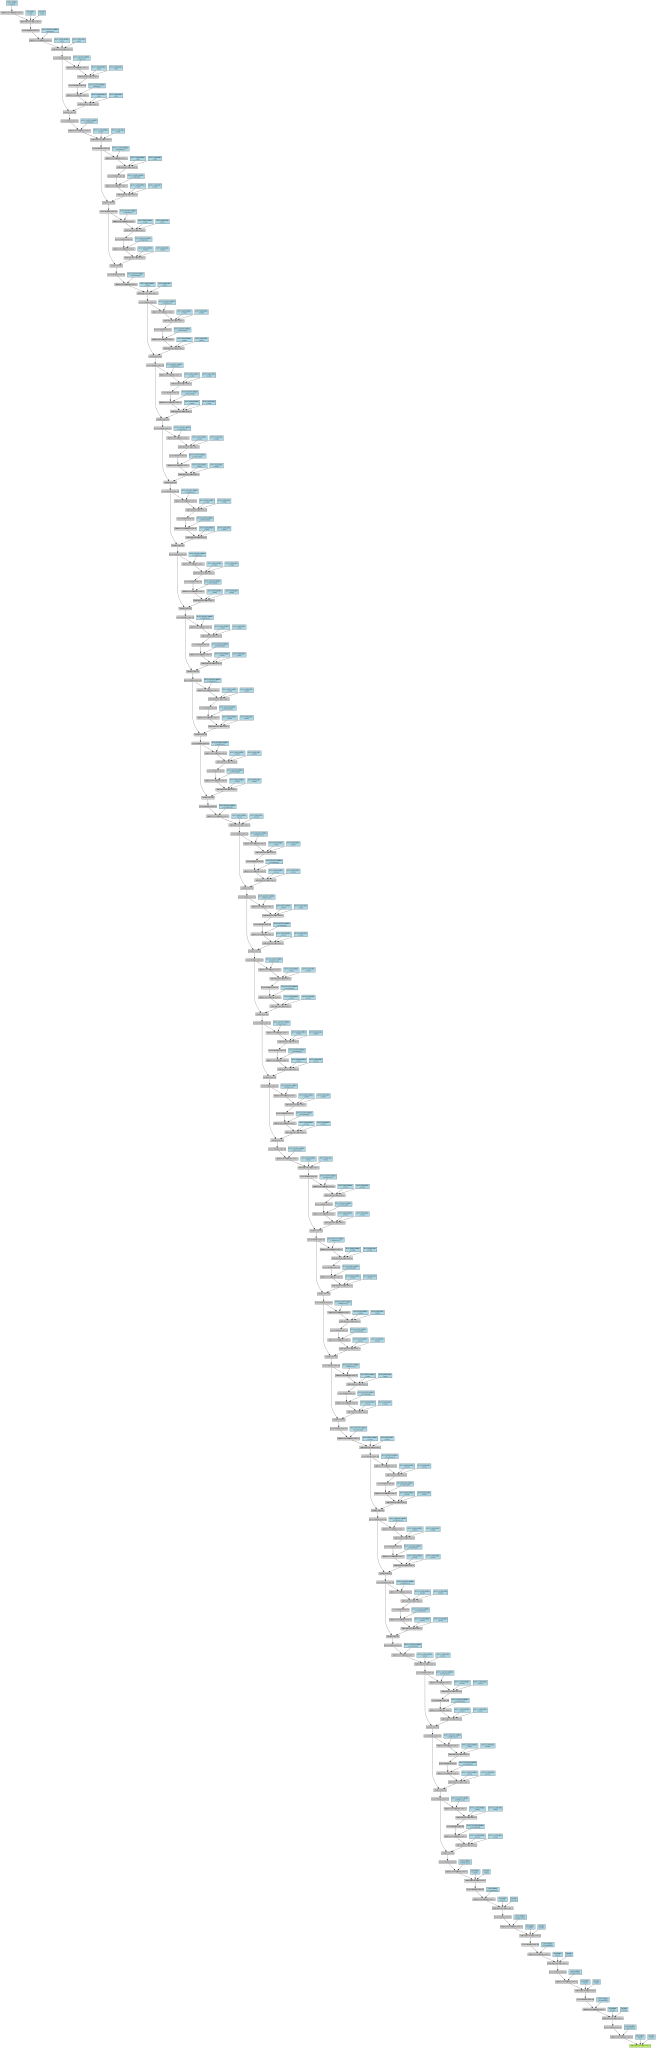

In [8]:
vis_graph